# Visualizing Layer Transformations
This notebook will take a look at both the convolutional and pooling layers, to see exactly how they affect an image, by displaying the output of each layer.

In [4]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import torch

## Pre-processing an Image:
First, get a color image and convert it to gray scale using openCV. Also, we will scale the image to be in range [0,1]:

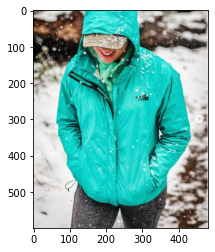

In [5]:
img_path = 'data/Untitled.png'
rgb_img = mpimg.imread(img_path)
plt.imshow(rgb_img);

In [6]:
# convert to gray-scale.
grs_img = cv2.cvtColor(rgb_img, cv2.COLOR_BGR2GRAY).astype('float32')

# scale to [0,1]
grs_img = grs_img/255

Display the converted and scaled image:

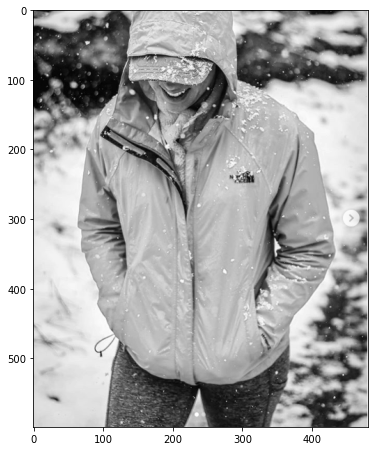

In [7]:
plt.figure(figsize=(6,8))
plt.imshow(grs_img, cmap='gray')

## Defining Filters:
We will define 4 filters for the convolution layer:

In [8]:
filter_vals = np.array([[-1, -1 , 1, 1]]*4)
filter_1 = filter_vals
filter_2 = -filter_1
filter_3 = filter_1.T
filter_4 = -filter_3

filters = np.array([filter_1, filter_2, filter_3, filter_4])
filters

array([[[-1, -1,  1,  1],
        [-1, -1,  1,  1],
        [-1, -1,  1,  1],
        [-1, -1,  1,  1]],

       [[ 1,  1, -1, -1],
        [ 1,  1, -1, -1],
        [ 1,  1, -1, -1],
        [ 1,  1, -1, -1]],

       [[-1, -1, -1, -1],
        [-1, -1, -1, -1],
        [ 1,  1,  1,  1],
        [ 1,  1,  1,  1]],

       [[ 1,  1,  1,  1],
        [ 1,  1,  1,  1],
        [-1, -1, -1, -1],
        [-1, -1, -1, -1]]])

Let's apply the first filter in the set to our gray-scale image, and visualize the results:

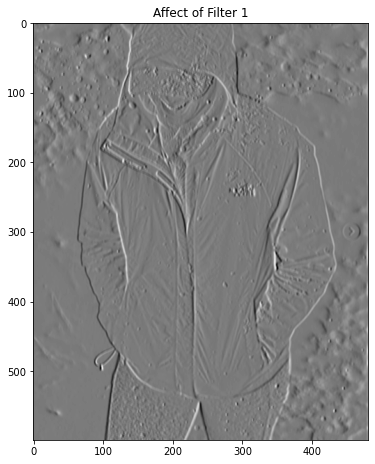

In [9]:
filtered_img = cv2.filter2D(grs_img, -1, filter_1)
plt.figure(figsize=(6,10))
plt.title("Affect of Filter 1")
plt.imshow(filtered_img, cmap='gray')
plt.show()

## Defining a Network
In this part we will define a network. This network is not designed to predict anything, but rather just to give us the raw results of each layer so that we can visualize them on our screen.

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self, weight):
        """
        Args:
            weights: the kernel values as a tensor (n_kernels, 1, k_height, k_width).
        """
        super(Net, self).__init__()
        
        # Get height and width of kernel
        k_height, k_width = weight.shape[2:]
        
        # define a 4 feature convolutional layer
        self.conv = nn.Conv2d(1, 4, kernel_size=(k_height, k_width), bias=False)
        self.conv.weight = torch.nn.Parameter(weight)
        
        # define a (2x2) pooling layer
        self.pool = nn.MaxPool2d(2,2)
        
    def forward(self, x):
        conv_x = self.conv(x)
        relu_x = F.relu(conv_x)
        pool_x = self.pool(relu_x)
        
        return conv_x, relu_x, pool_x
        

In [11]:
kernels = torch.from_numpy(filters).unsqueeze(1).type(torch.FloatTensor)
model = Net(kernels)
model

Net(
  (conv): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

## Visualizing the Output of Each Layer:
First, let's get the output of each layer and take a look at them visually. We will define a helper function to give us a visualization of an arbitrary layer in the network:

In [12]:
def viz_layer(layer, n_filters):
    fig, axes = plt.subplots(nrows=1, ncols=n_filters, figsize=(20,20))
    for i in range(n_filters):
        axes[i].imshow(np.squeeze(layer[0, i].data.numpy()), cmap='gray')
        axes[i].set_title(f'Output {i+1}')

Next, we will format the gray scale image as a tensor with the appropriate dimensions for the model to take.

The appropriate shape for an image to be fed to a network is `(n_samples, n_channels, height, width)`:

In [13]:
img_tensor = torch.from_numpy(grs_img).unsqueeze(0).unsqueeze(1)

# Shape of the original image, Shape of the model input:
grs_img.shape, img_tensor.shape

((599, 481), torch.Size([1, 1, 599, 481]))

# Convolutional Layer:
Let's get the output of each of three layers, and visualize them, starting with the convolutional layer.

In [14]:
conv_out, relu_out, pool_out = model(img_tensor)

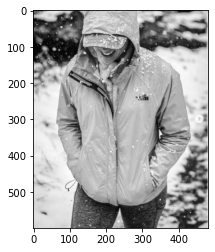

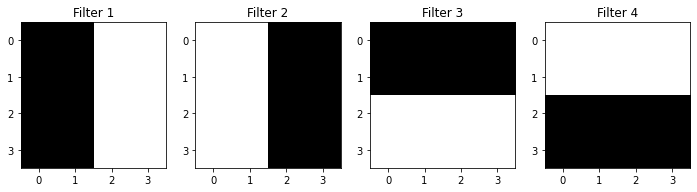

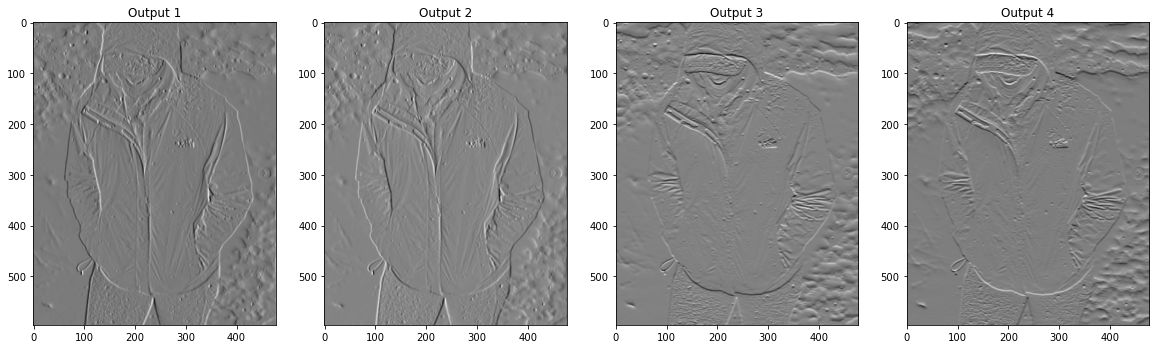

In [15]:
plt.imshow(grs_img, cmap='gray')

n_filters = 4
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(12,6))
for i in range(n_filters):
    axes[i].imshow(filters[i], cmap='gray')
    axes[i].set_title(f'Filter {i+1}')
plt.show()

viz_layer(conv_out, 4)

# Pooled Layer:

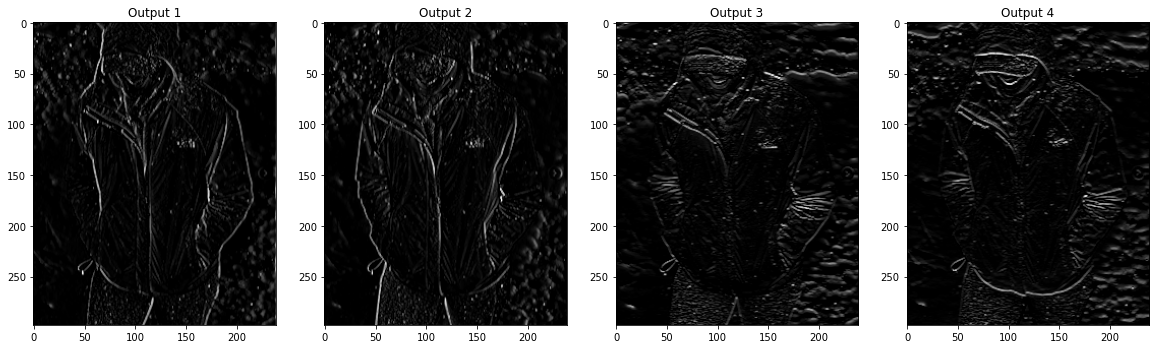

In [16]:
viz_layer(pool_out, 4)

So we see that the final output from the pooled layer is reduced version of the output from the convolutional layer. Notice that the width and height have roughly been reduced by a factor of 2 from 600x480 to approximately 300x250. 

You may be wondering why the pooled layer output is now largely black. That is a the affect of the ReLU layer on the convolutional layer output. Relu is defined as:


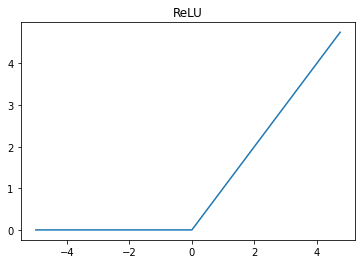

In [17]:
def ReLU(x):
    return [0 if xi < 0 else xi for xi in x]

x = np.arange(-5, 5, 0.25)
plt.title('ReLU')
plt.plot(x, ReLU(x));

So we see that all pixels that have a negative value after a filter pass are given a value of '0', which leads to them turning black.